In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers.merge import add

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Prepare Data

In [3]:
# load data

df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST 

In [5]:
# As shown above, The Worldpost and worldpost should be  the same category so merge them
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [6]:
# using headlines and short_descriptions as input X

df['text'] = df.headline + " " + df.short_description

In [7]:
df['text'][0]

'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV She left her husband. He killed their children. Just another day in America.'

In [8]:
# Tokenizing

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X =tokenizer.texts_to_sequences(df.text)
df['words'] = X

In [9]:
# Deleting some empty and short data

df['word_length'] = df.words.apply(lambda i : len(i))
df = df[df.word_length >= 5]

df.head()


,category,headline,authors,link,short_description,date,text,words,word_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,"[74, 101, 257, 1331, 3001, 6, 698, 134, 96, 26...",27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,"[42, 1604, 2960, 27762, 5, 25929, 5237, 8, 1, ...",20
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,"[5877, 5334, 8083, 8, 1, 76, 54, 21, 414, 8469...",25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[2710, 13374, 3596, 64143, 2295, 13055, 5, 569...",26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,"[41003, 36082, 1513, 97, 48, 7915, 3134, 2, 96...",26


In [10]:
df.word_length.describe()

count    199914.000000
mean         29.725032
std          14.024717
min           5.000000
25%          20.000000
50%          29.000000
75%          36.000000
max         248.000000
Name: word_length, dtype: float64

In [11]:
#  Using 50 for padding length

maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen = maxlen))

In [12]:
# Category to id

categories = df.groupby('category').size().index.tolist()
category_int= {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({k:i})

df['category_to_id'] = df['category'].apply(lambda x: category_int[x])

## Glove embedding

In [13]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
glove = open('glove.6B.100d.txt')
for line in glove:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
glove.close()

print('Found %s  unique tokens.' %len(word_index))
print('Total %s word vectors.' %len(embeddings_index))

Found 116617  unique tokens.
Total 400000 word vectors.


In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)


# Split Dataset

In [16]:
# prepared data 

X = np.array(X)
Y = np_utils.to_categorical(list(df.category_to_id))

# and split to training set and validation set

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)


## Text CNN

In [17]:
inp = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(len(int_category), activation='softmax')(drop)

TextCNN = Model(inputs=inp, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      11661800    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 64)       12864       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 50, 64)       19264       embedding_1[0][0]     

In [19]:
textcnn_history = TextCNN.fit(x_train, 
                              y_train, 
                              batch_size=128, 
                              epochs=2, 
                              validation_data=(x_val, y_val))


Train on 159931 samples, validate on 39983 samples
Epoch 1/2
159931/159931 [==============================] - 186s 1ms/step - loss: 1.9213 - acc: 0.4850 - val_loss: 1.6545 - val_acc: 0.5527
Epoch 2/2
159931/159931 [==============================] - 185s 1ms/step - loss: 1.8235 - acc: 0.5104 - val_loss: 1.6002 - val_acc: 0.5658


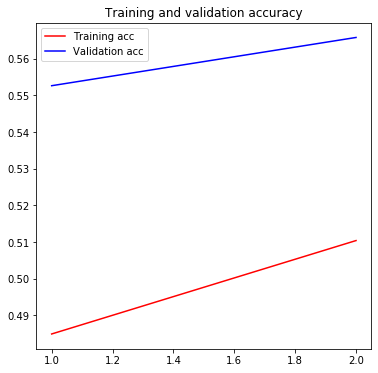

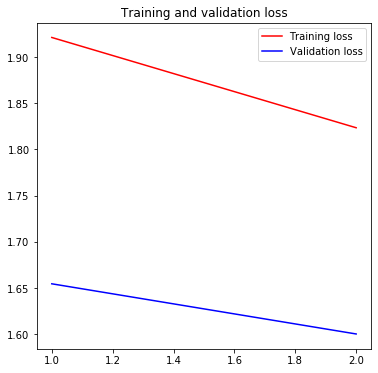

In [20]:
acc = textcnn_history.history['acc']
val_acc = textcnn_history.history['val_acc']
loss = textcnn_history.history['loss']
val_loss = textcnn_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

## Bidirectional GRU + Conv

In [21]:
# Bidrectional LSTM with convolution
# from https://www.kaggle.com/eashish/bidirectional-gru-with-convolution

inp = Input(shape=(maxlen,), dtype='int32')
x = embedding_layer(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size=3)(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
outp = Dense(len(int_category), activation="softmax")(x)

BiGRU = Model(inp, outp)
BiGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

BiGRU.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      11661800    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 50, 100)      0           embedding_1[1][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 256)      175872      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_4 (

In [22]:
# training

bigru_history = BiGRU.fit(x_train, 
                          y_train, 
                          batch_size=128, 
                          epochs=2, 
                          validation_data=(x_val, y_val))

Train on 159931 samples, validate on 39983 samples
Epoch 1/2
159931/159931 [==============================] - 751s 5ms/step - loss: 1.8613 - acc: 0.4992 - val_loss: 1.4847 - val_acc: 0.5849
Epoch 2/2
159931/159931 [==============================] - 738s 5ms/step - loss: 1.5178 - acc: 0.5744 - val_loss: 1.3915 - val_acc: 0.6051


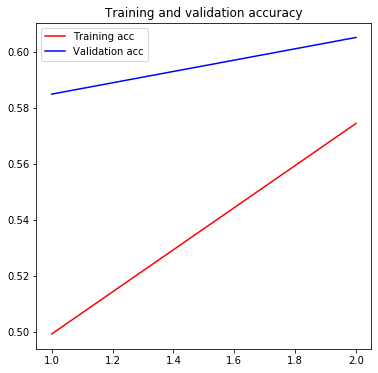

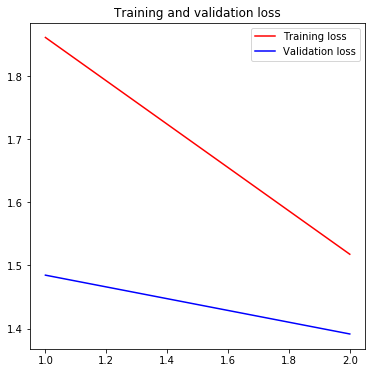

In [23]:
plt.rcParams['figure.figsize'] = (6,6)

acc = bigru_history.history['acc']
val_acc = bigru_history.history['val_acc']
loss = bigru_history.history['loss']
val_loss = bigru_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

## LSTM with Attention

In [24]:
# from https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043/code

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    

lstm_layer = LSTM(300, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)

inp = Input(shape=(maxlen,), dtype='int32')
embedding= embedding_layer(inp)
x = lstm_layer(embedding)
x = Dropout(0.25)(x)
merged = Attention(maxlen)(x)
merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.25)(merged)
merged = BatchNormalization()(merged)
outp = Dense(len(int_category), activation='softmax')(merged)

AttentionLSTM = Model(inputs=inp, outputs=outp)
AttentionLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

AttentionLSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 100)           11661800  
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 300)           481200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
attention_1 (Attention)      (None, 300)               350       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
__________

In [29]:
attlstm_history = AttentionLSTM.fit(x_train, 
                                    y_train, 
                                    batch_size=128, 
                                    epochs=1, 
                                    validation_data=(x_val, y_val))

Train on 159931 samples, validate on 39983 samples
Epoch 1/1
159931/159931 [==============================] - 1822s 11ms/step - loss: 1.8205 - acc: 0.5065 - val_loss: 1.4746 - val_acc: 0.5835


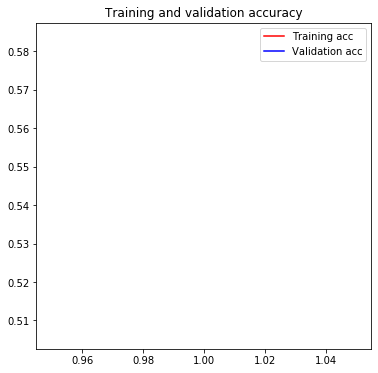

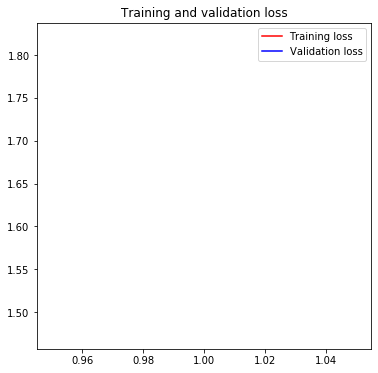

In [30]:
acc = attlstm_history.history['acc']
val_acc = attlstm_history.history['val_acc']
loss = attlstm_history.history['loss']
val_loss = attlstm_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [31]:
# confusion matrix

predicted = AttentionLSTM.predict(x_val)
cm = pd.DataFrame(confusion_matrix(y_val.argmax(axis=1), predicted.argmax(axis=1)))

In [32]:
from IPython.display import display
pd.options.display.max_columns = None
display(cm)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,81,6,2,3,0,0,0,31,0,0,59,0,0,5,0,1,10,2,2,1,0,0,1,0,16,2,3,2,0,8,1,0,2,24,0,2,26,6,0,6
1,18,24,3,2,1,1,0,19,0,0,73,0,0,6,0,1,3,3,2,1,1,0,3,2,38,6,2,1,0,6,2,0,4,9,0,3,6,10,0,3
2,4,0,157,7,5,4,30,3,1,9,247,1,0,12,0,2,7,1,18,1,4,0,12,5,231,16,12,2,26,1,21,0,3,12,0,0,21,7,0,9
3,4,0,1,432,1,0,3,1,0,10,35,0,0,21,0,19,49,8,8,0,4,28,17,1,269,8,0,4,6,7,7,4,30,32,1,2,135,8,0,28
4,0,0,2,5,38,0,4,0,1,41,6,0,0,2,0,1,8,3,6,0,0,0,7,0,71,0,1,0,3,1,0,0,1,1,0,0,20,2,0,0
5,2,1,8,4,1,218,1,1,0,0,252,4,0,23,0,7,38,5,0,0,11,0,25,8,240,3,2,4,18,8,12,0,19,17,1,13,38,6,0,2
6,0,0,10,0,6,0,297,0,0,0,39,0,0,3,0,15,1,2,2,0,1,1,11,1,194,3,3,0,10,0,1,0,1,7,1,20,16,2,0,23
7,24,3,2,3,0,1,0,90,0,0,39,0,0,4,0,1,1,3,1,0,0,0,6,0,5,4,0,1,0,1,7,0,2,13,0,0,13,3,0,2
8,0,0,0,1,0,0,0,0,465,0,39,0,1,2,0,0,7,0,1,0,0,1,62,3,13,0,0,1,0,0,5,0,2,8,23,0,62,9,0,2
9,1,0,2,6,1,0,0,0,0,66,1,0,0,1,0,0,2,0,13,0,0,5,23,2,41,2,0,0,1,0,0,0,0,3,0,0,23,0,0,0


## evaluate accuracy

In [33]:
def evaluate_accuracy(model):
    predicted = model.predict(x_val)
    diff = y_val.argmax(axis=-1) - predicted.argmax(axis=-1)
    corrects = np.where(diff == 0)[0].shape[0]
    total = y_val.shape[0]
    return float(corrects/total)


In [34]:
print("model TextCNN accuracy:          %.6f" % evaluate_accuracy(TextCNN))
print("model Bidirectional GRU + Conv:  %.6f" % evaluate_accuracy(BiGRU))
print("model LSTM with Attention:       %.6f" % evaluate_accuracy(AttentionLSTM))


model TextCNN accuracy:          0.565815
model Bidirectional GRU + Conv:  0.605107
model LSTM with Attention:       0.583548


## Ensemble

In [35]:
def evaluate_accuracy_ensemble(models):
    res = np.zeros(shape=y_val.shape)
    for model in models:
        predicted = model.predict(x_val)
        res += predicted
    res /= len(models)
    diff = y_val.argmax(axis=-1) - res.argmax(axis=-1)
    corrects = np.where(diff == 0)[0].shape[0]
    total = y_val.shape[0]
    return float(corrects/total)

In [36]:
print(evaluate_accuracy_ensemble([TextCNN, BiGRU, AttentionLSTM]))


0.6062076382462547


## The Ensemble accuracy is Less because we have taken Epoch is 1 and 2 as least. If we take more epoch then our accuracy will increase,As my computational power is less so I didn't use much hyperpaters